In [1]:
lr = 1e-3 
epoch = 5
batch_size = 64

In [2]:
import tensorflow as tf
import numpy as np
tf.reset_default_graph()
tf.set_random_seed(0)
np.random.seed(0)

In [3]:
(x_train, y_train_cls), (x_test, y_test_cls) = tf.keras.datasets.mnist.load_data()
x_train = x_train.astype(np.float32).reshape((-1, 28, 28, 1)) / 255.0
x_test = x_test.astype(np.float32).reshape((-1, 28, 28, 1)) / 255.0

In [4]:
x = tf.placeholder(tf.float32, shape=[None, 28, 28, 1], name='x') 
y_cls = tf.placeholder(tf.int32, shape=[None,], name='y_cls')

init_w = tf.keras.initializers.he_uniform()
init_b = tf.keras.initializers.zeros()

w1 = tf.get_variable("w1", shape=[3, 3, 1, 32], initializer=init_w)  
y1 = tf.nn.conv2d(input=x, filter=w1, strides=[1, 1, 1, 1], padding='SAME')
y1 = tf.nn.max_pool(value=y1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
y1 = tf.nn.relu(y1)

w2 = tf.get_variable("w2", shape=[3, 3, 32, 64], initializer=init_w)  
y2 = tf.nn.conv2d(input=y1, filter=w2, strides=[1, 1, 1, 1], padding='SAME')
y2 = tf.nn.max_pool(value=y2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
y2 = tf.nn.relu(y2) 

w3 = tf.get_variable("w3", shape=[3, 3, 64, 64], initializer=init_w)  
y3 = tf.nn.conv2d(input=y2, filter=w3, strides=[1, 1, 1, 1], padding='SAME')
y3 = tf.nn.relu(y3) 

y3 = tf.reshape(y3, [-1, y3.get_shape()[1:].num_elements()])

init_w = tf.keras.initializers.he_uniform()

w4 = tf.get_variable("w4", shape=[y3.get_shape()[1:].num_elements(), 64], initializer=init_w)  
b4 = tf.get_variable("b4", shape=[64,], initializer=init_b)
y4 = tf.nn.relu(y3@w4+b4) 

w5 = tf.get_variable("w5", shape=[64, 10], initializer=init_w) 
b5 = tf.get_variable("b5", shape=[10,], initializer=init_b)
logits = tf.identity(y4@w5+b5, name='logits')

y_pred_cls = tf.cast(tf.argmax(logits, axis=1), tf.int32, name='y_pred_cls') 

entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y_cls, logits=logits) 
loss = tf.reduce_mean(entropy) 
train = tf.train.RMSPropOptimizer(lr).minimize(loss)

correct = tf.nn.in_top_k(logits, y_cls, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()
saver = tf.train.Saver()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [5]:
def shuffle_batch(x, y, batch_size):
    rnd_idx = np.random.permutation(len(x))
    n_batches = len(x) // batch_size
    for batch_idx in np.array_split(rnd_idx, n_batches):
        yield x[batch_idx], y[batch_idx]

In [6]:
with tf.Session() as sess:
    init.run()
    #saver.restore(sess, 'save/nn.ckpt')
    
    loss_trace = []
    accuracy_trace = []

    for i in range(epoch):
        print()
        print('epoch {}/{}'.format(i, epoch), end=' ')
        for x_batch, y_batch_cls in shuffle_batch(x_train, y_train_cls, batch_size):
            feed_dict = {x: x_batch, y_cls: y_batch_cls}
            loss_run, accuracy_run, _ = sess.run([loss, accuracy, train], feed_dict=feed_dict)
            loss_trace.append(loss_run)
            accuracy_trace.append(accuracy_run)

    feed_dict = {x: x_test, y_cls: y_test_cls}
    accuracy_run, y_test_pred_cls = sess.run([accuracy, y_pred_cls], feed_dict=feed_dict)
    
    saver.save(sess, 'save/nn.ckpt')


epoch 0/5 
epoch 1/5 
epoch 2/5 
epoch 3/5 
epoch 4/5 

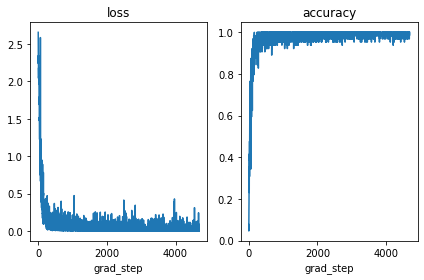

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(loss_trace)
ax2.plot(accuracy_trace)
ax1.set_title('loss')
ax2.set_title('accuracy')
ax1.set_xlabel('grad_step')
ax2.set_xlabel('grad_step')
plt.tight_layout()
plt.show()

In [8]:
print('Test Accuracy :', accuracy_run)

# he_normal, he_normal   0.9891
# he_normal, he_uniform  0.9913
# he_uniform, he_normal  0.9902
# he_uniform, he_uniform 0.9923

# glorot_normal, glorot_normal   0.9893
# glorot_normal, glorot_uniform  0.9907
# glorot_uniform, glorot_normal  0.9914
# glorot_uniform, glorot_uniform 0.9883

Test Accuracy : 0.9923


In [9]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true=y_test_cls, y_pred=y_test_pred_cls)
print(cm)

[[ 970    0    1    0    0    0    4    1    1    3]
 [   0 1130    0    1    0    1    1    2    0    0]
 [   0    0 1024    0    0    0    3    3    2    0]
 [   0    0    0 1008    0    1    0    0    1    0]
 [   0    0    0    0  977    0    2    0    0    3]
 [   1    0    0    5    0  883    2    0    0    1]
 [   3    2    0    0    4    0  949    0    0    0]
 [   0    1    4    0    0    0    0 1022    1    0]
 [   2    0    1    0    0    1    1    1  966    2]
 [   0    1    0    2    7    1    0    3    1  994]]


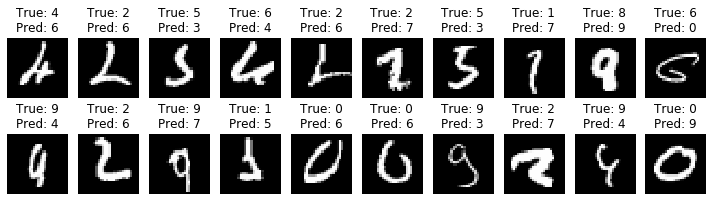

In [10]:
fig, axes = plt.subplots(2, 10, figsize=(10,3))
idx = 0
for ax in axes.reshape((-1,)):
    while True:
        if y_test_cls[idx]==y_test_pred_cls[idx]:
            idx += 1
        else:
            ax.imshow(x_test[idx].reshape((28,28)), cmap=plt.cm.gray)
            ax.set_title('True: {}\nPred: {}'.format(y_test_cls[idx], y_test_pred_cls[idx]))
            ax.axis('off')
            idx += 1
            break
plt.tight_layout()
plt.show()